# Enron ML Project
***by Bruno de Assis Pereira***

---
In this project, I am going to present a development process of a **Machine Learning** project and I am going to use the [**Enron Dataset**](https://www.kaggle.com/wcukierski/enron-email-dataset).

This dataset contains emails generated by employees of the Enron Corporation and some informations related to finances. The Enron was involved in a huge fraude.

The goal here is to be able to identify **Persons of Interest (*POI*)** which is the people that were somehow related to the fraud.

In [1]:
#!/usr/bin/python
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import pickle
sys.path.append("../tools/")

import pandas as pd
import numpy as np
import math
from IPython.display import display
from itertools import combinations

from feature_format import featureFormat, targetFeatureSplit
from tester import *

C:\Users\Bruno\Anaconda2\envs\DAND\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


---
### Taking a look over the dataset 
---

In [2]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
### Storing data in a dataframe to simplify data manipulation
enron_df = pd.DataFrame.from_dict(data_dict, orient='index')
display(enron_df.head(3))
enron_df.info()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39


<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       146 non-null object
to_messages                  146 non-null object
deferral_payments            146 non-null object
total_payments               146 non-null object
exercised_stock_options      146 non-null object
bonus                        146 non-null object
restricted_stock             146 non-null object
shared_receipt_with_poi      146 non-null object
restricted_stock_deferred    146 non-null object
total_stock_value            146 non-null object
expenses                     146 non-null object
loan_advances                146 non-null object
from_messages                146 non-null object
other                        146 non-null object
from_this_person_to_poi      146 non-null object
poi                          146 non-null bool
director_fees                146 non-null object
deferred_income              146 non-null object


In [3]:
enron_df['poi'].value_counts()

False    128
True      18
Name: poi, dtype: int64

---
This dataset contains **146 rows** and **21 features**.

In the table, we can see that we have some _NaN_ values.

Besides that, we have only one variable that is a _boolean_ which is the column **poi** that identifies each registers as a person of interest or not.

All of the other columns, are composed by numbers, except the *email_address*.

Another interesting thing to take into account is that we have only **18 POIs**.

Ok, so let's take a look at how this data is distributed.

### Looking for *Outliers*
To achieve better results with our Machine Learning models, it is a good idea to deal with outliers within the dataset.

To find these anomalies, we can develop some visualizations over the data and use some statistical metrics.

---

In [4]:
def generate_scatter_plot(x, y, ax):
    """
    Method created to plot features data points and POIs
    """
    enron_df.plot(
        kind='scatter',
        x=x,
        y=y,
        ax=ax
    )
    
    enron_df[enron_df['poi'] == True].plot(
        kind='scatter',
        x=x,
        y=y,
        color='r',
        marker='*',
        ax=ax
    )
    
    ax.set_title('{} X {}'.format(y,x))

---
Since we already know that we have _NaN_ values, before performing any kind of alter, let's see if is there any row that is composed only by _NaNs_.

---

In [5]:
### Removing column 'poi' since it is composed only by True and False values
enron_df[enron_df.drop(['poi'], axis=1).eq(enron_df.iloc[:,0], axis=0).all(1) == True]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
LOCKHART EUGENE E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN


---
Since this row does not present any relevant value, I am going to remove it.

---

In [6]:
### Removing identified outlier
enron_df.drop('LOCKHART EUGENE E', inplace=True)

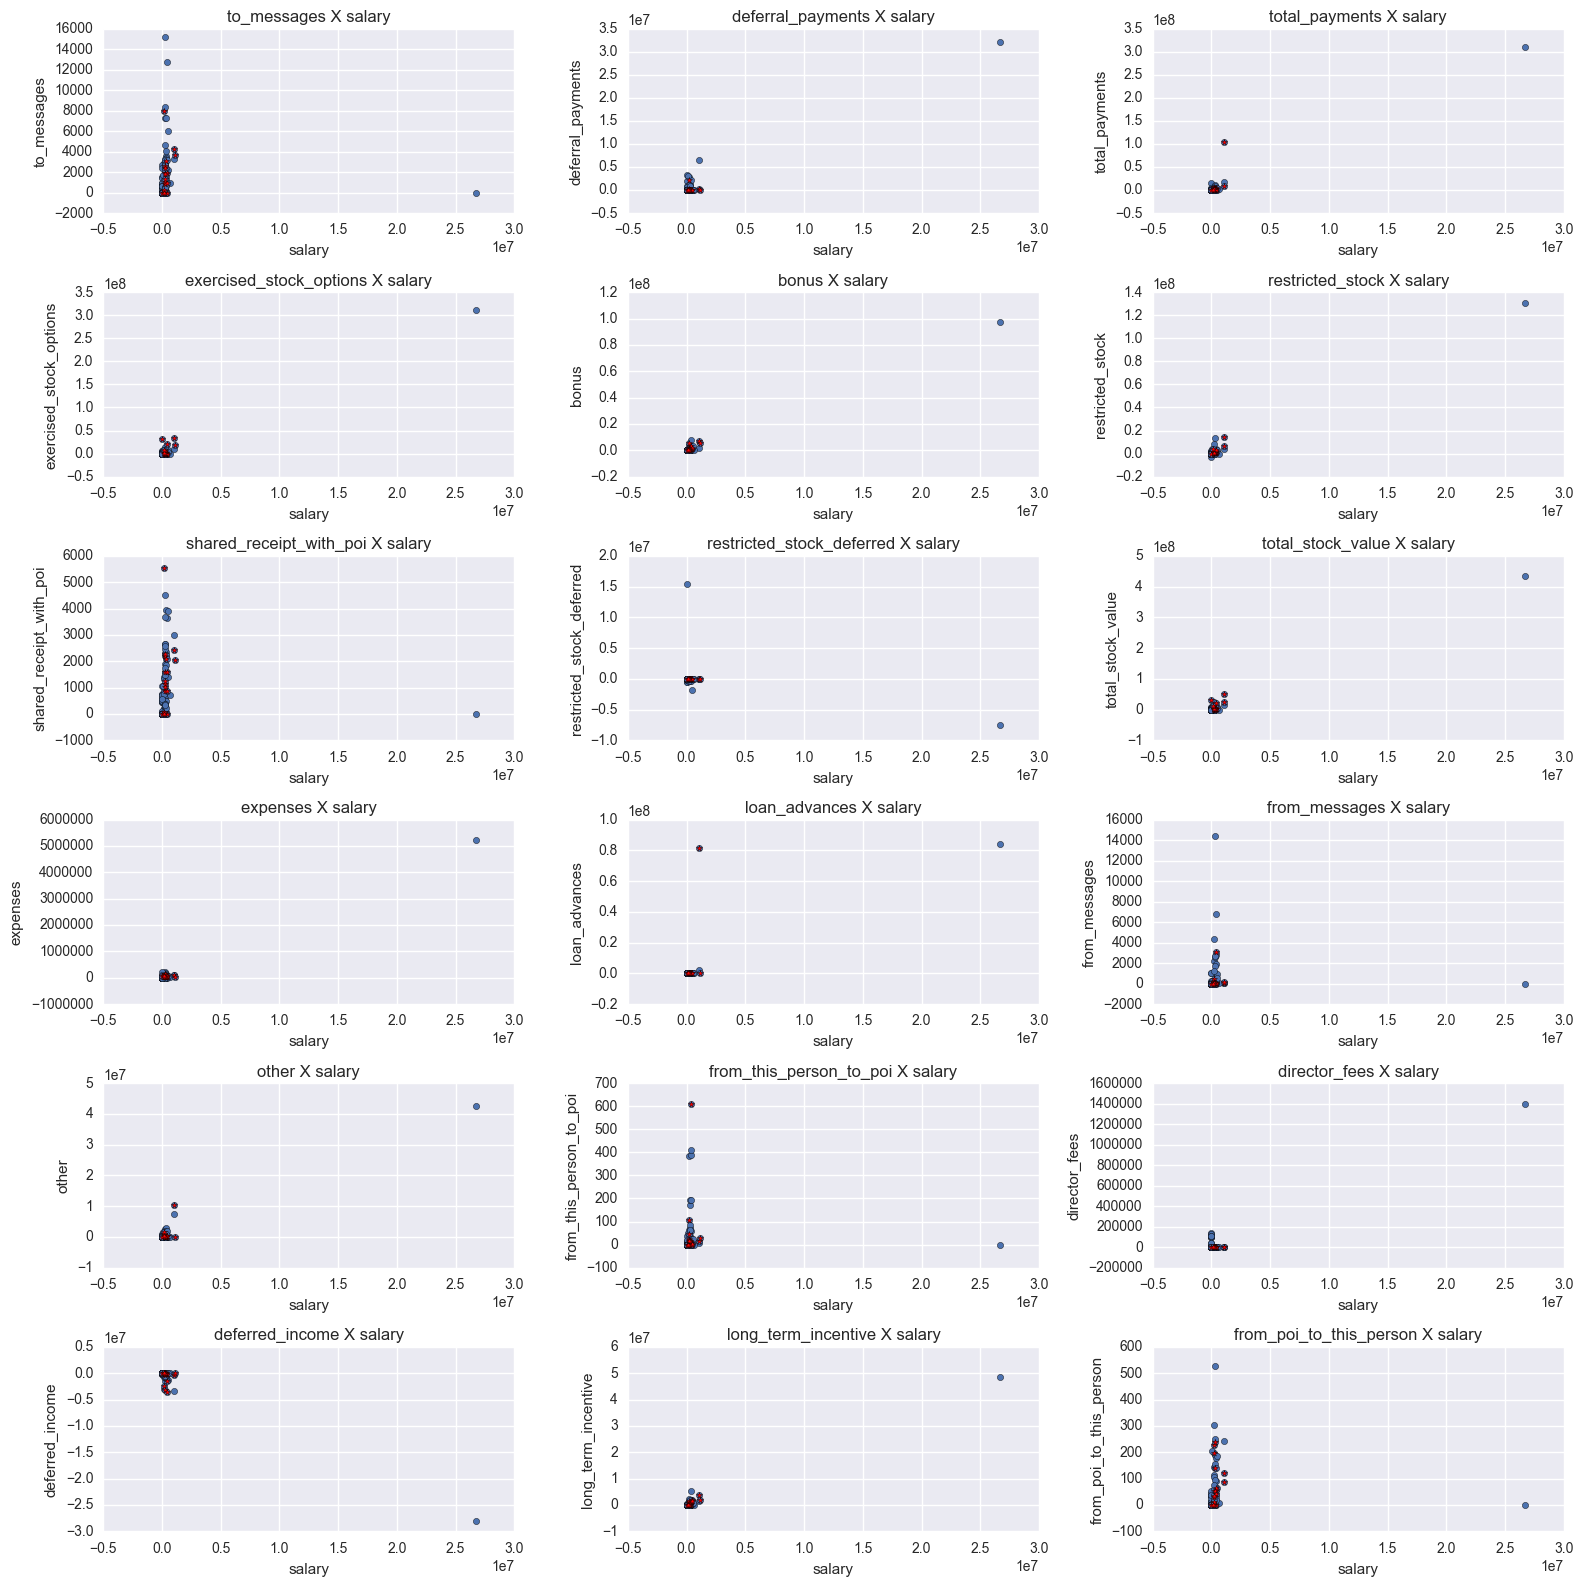

In [7]:
### Replacing NaN's
enron_df.replace(to_replace={'NaN':0}, inplace=True)

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16,16))

### Removing 'poi' and the categorical variable 'email_address'
cols_to_analyse = [x for x in enron_df.columns if x not in ['poi', 'email_address']]

comb_list = []

for i, tp in enumerate(combinations(cols_to_analyse, 2)):
    comb_list.append(tp)
    if tp[0] == 'salary' and tp[1] != 'poi' and tp[1] != 'email_address':
        generate_scatter_plot(tp[0], tp[1], axes[i/3][i%3])

plt.tight_layout()

---
For every combination of features, it is possible to notice a point that is very far from the others.

This point is the **TOTAL** row.

It does not make sense to keep this line throughout the analysis.

---

In [8]:
### Removing identified outlier
enron_df.drop('TOTAL', inplace=True)

---
Since we have found a _row_ that did not make sense to keep, let's take a look at all other names.

Once we are dealing with only **146 rows**, it becomes possible to analyse each one.

---

In [9]:
enron_df.index.tolist()

['ALLEN PHILLIP K',
 'BADUM JAMES P',
 'BANNANTINE JAMES M',
 'BAXTER JOHN C',
 'BAY FRANKLIN R',
 'BAZELIDES PHILIP J',
 'BECK SALLY W',
 'BELDEN TIMOTHY N',
 'BELFER ROBERT',
 'BERBERIAN DAVID',
 'BERGSIEKER RICHARD P',
 'BHATNAGAR SANJAY',
 'BIBI PHILIPPE A',
 'BLACHMAN JEREMY M',
 'BLAKE JR. NORMAN P',
 'BOWEN JR RAYMOND M',
 'BROWN MICHAEL',
 'BUCHANAN HAROLD G',
 'BUTTS ROBERT H',
 'BUY RICHARD B',
 'CALGER CHRISTOPHER F',
 'CARTER REBECCA C',
 'CAUSEY RICHARD A',
 'CHAN RONNIE',
 'CHRISTODOULOU DIOMEDES',
 'CLINE KENNETH W',
 'COLWELL WESLEY',
 'CORDES WILLIAM R',
 'COX DAVID',
 'CUMBERLAND MICHAEL S',
 'DEFFNER JOSEPH M',
 'DELAINEY DAVID W',
 'DERRICK JR. JAMES V',
 'DETMERING TIMOTHY J',
 'DIETRICH JANET R',
 'DIMICHELE RICHARD G',
 'DODSON KEITH',
 'DONAHUE JR JEFFREY M',
 'DUNCAN JOHN H',
 'DURAN WILLIAM D',
 'ECHOLS JOHN B',
 'ELLIOTT STEVEN',
 'FALLON JAMES B',
 'FASTOW ANDREW S',
 'FITZGERALD JAY L',
 'FOWLER PEGGY',
 'FOY JOE',
 'FREVERT MARK A',
 'FUGH JOHN L',
 'GAHN 

---
And for my surprise, there is a "person" that is not a person: **'THE TRAVEL AGENCY IN THE PARK'**.

Since we are looking for POIs (**persons** of interest), well, it does not make sense to keep this one either.

---

In [10]:
### Removing identified outlier
enron_df.drop('THE TRAVEL AGENCY IN THE PARK', inplace=True)

---
After removing those rows, let's take a look again at how our data is spread.

---

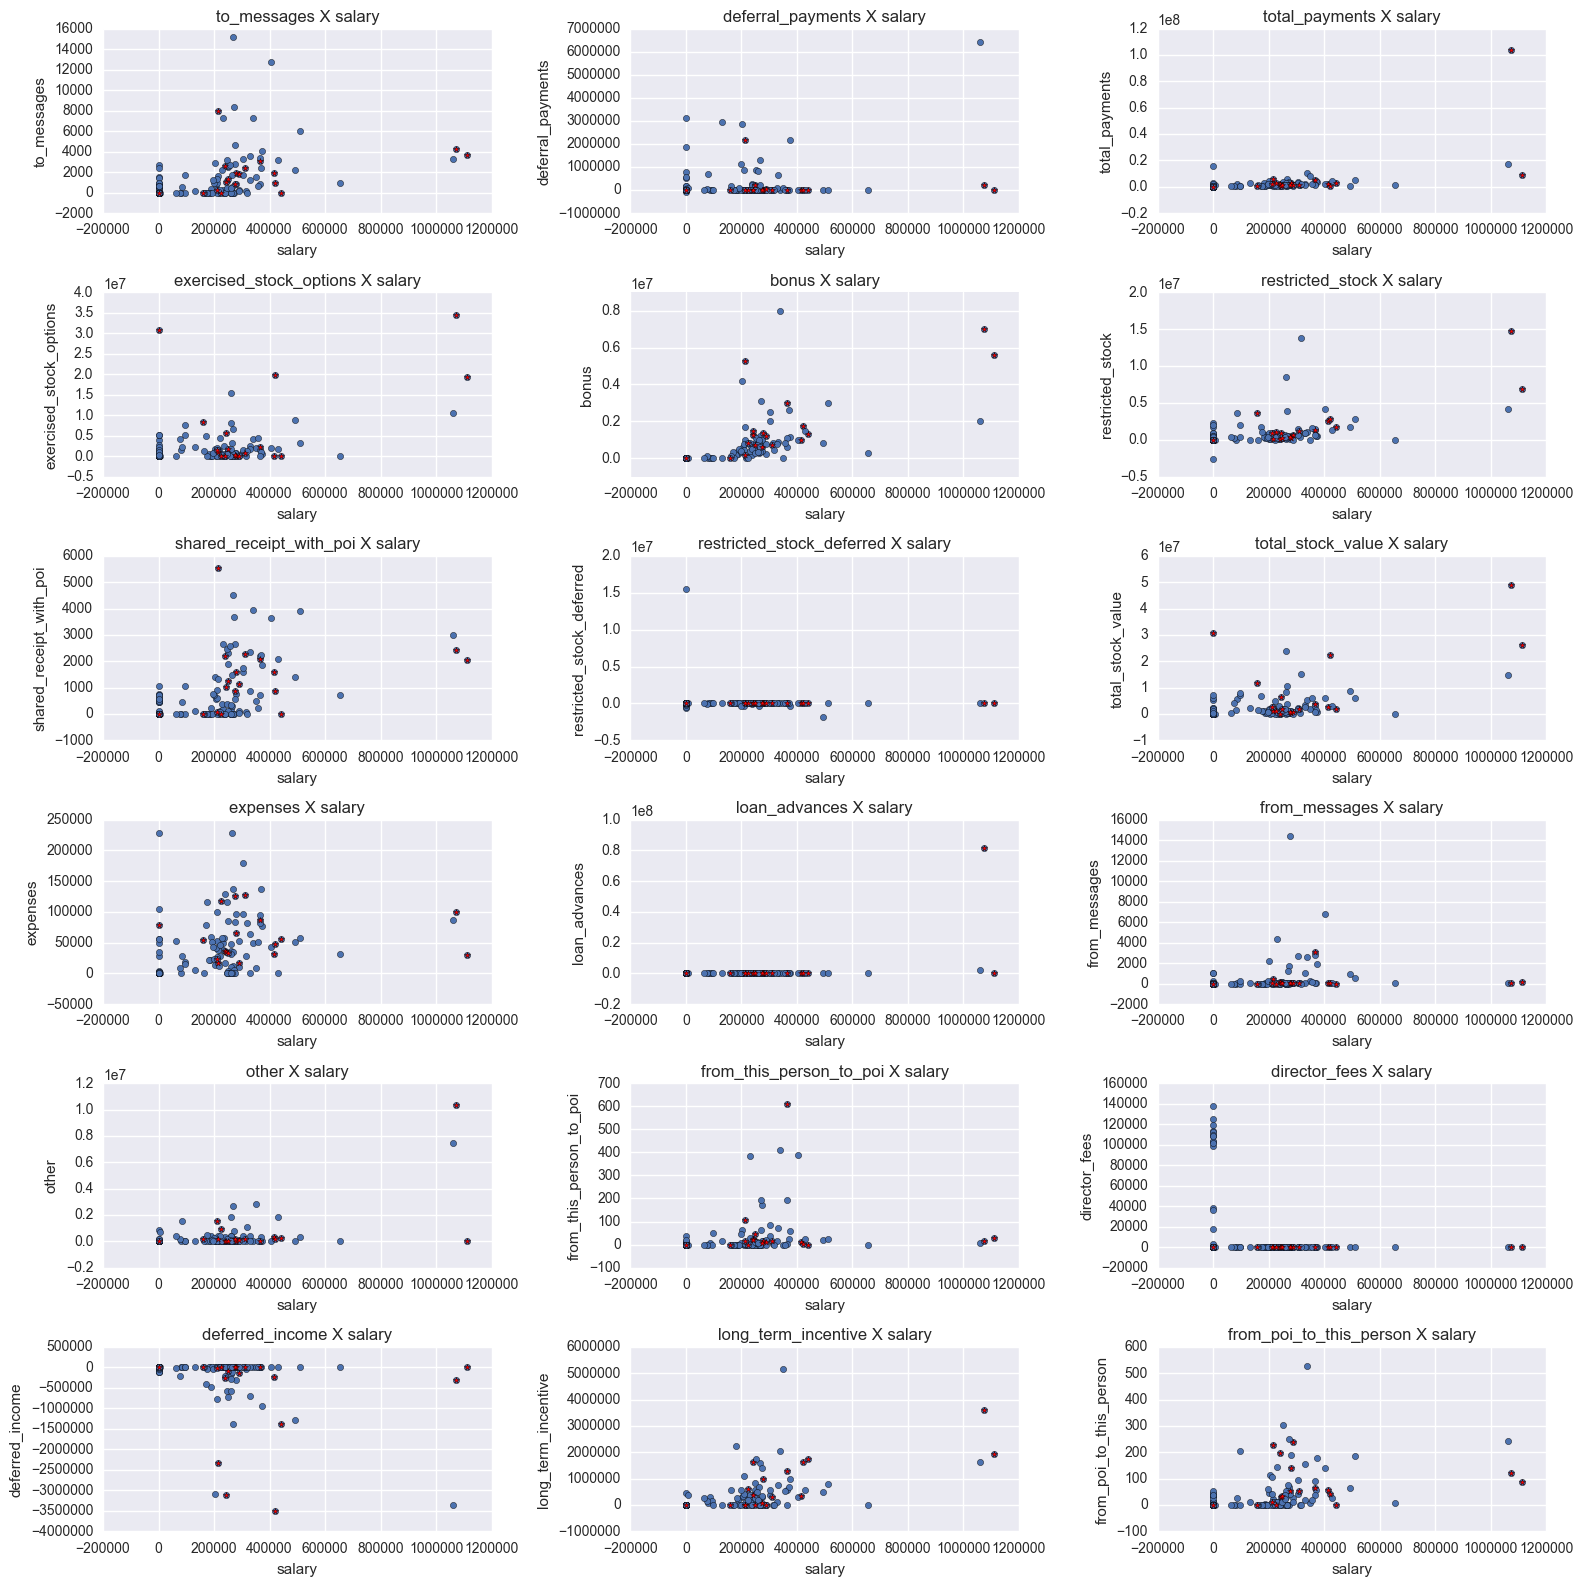

In [11]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16,16))

for i, tp in enumerate(comb_list):
    if tp[0] == 'salary' and tp[1] != 'poi' and tp[1] != 'email_address':
        generate_scatter_plot(tp[0], tp[1], axes[i/3][i%3])

plt.tight_layout()

---
We can still see that some points are very distant from the main cluster and that they are isolated.

---

In [12]:
### Changing the outliers - values higher than the mean plus two times the standard deviation
for col in cols_to_analyse:
    threshold = 2*enron_df[col].std()+enron_df[col].mean()
    ### Setting outliers to 0
    enron_df.loc[enron_df[col] > threshold, col] = 0

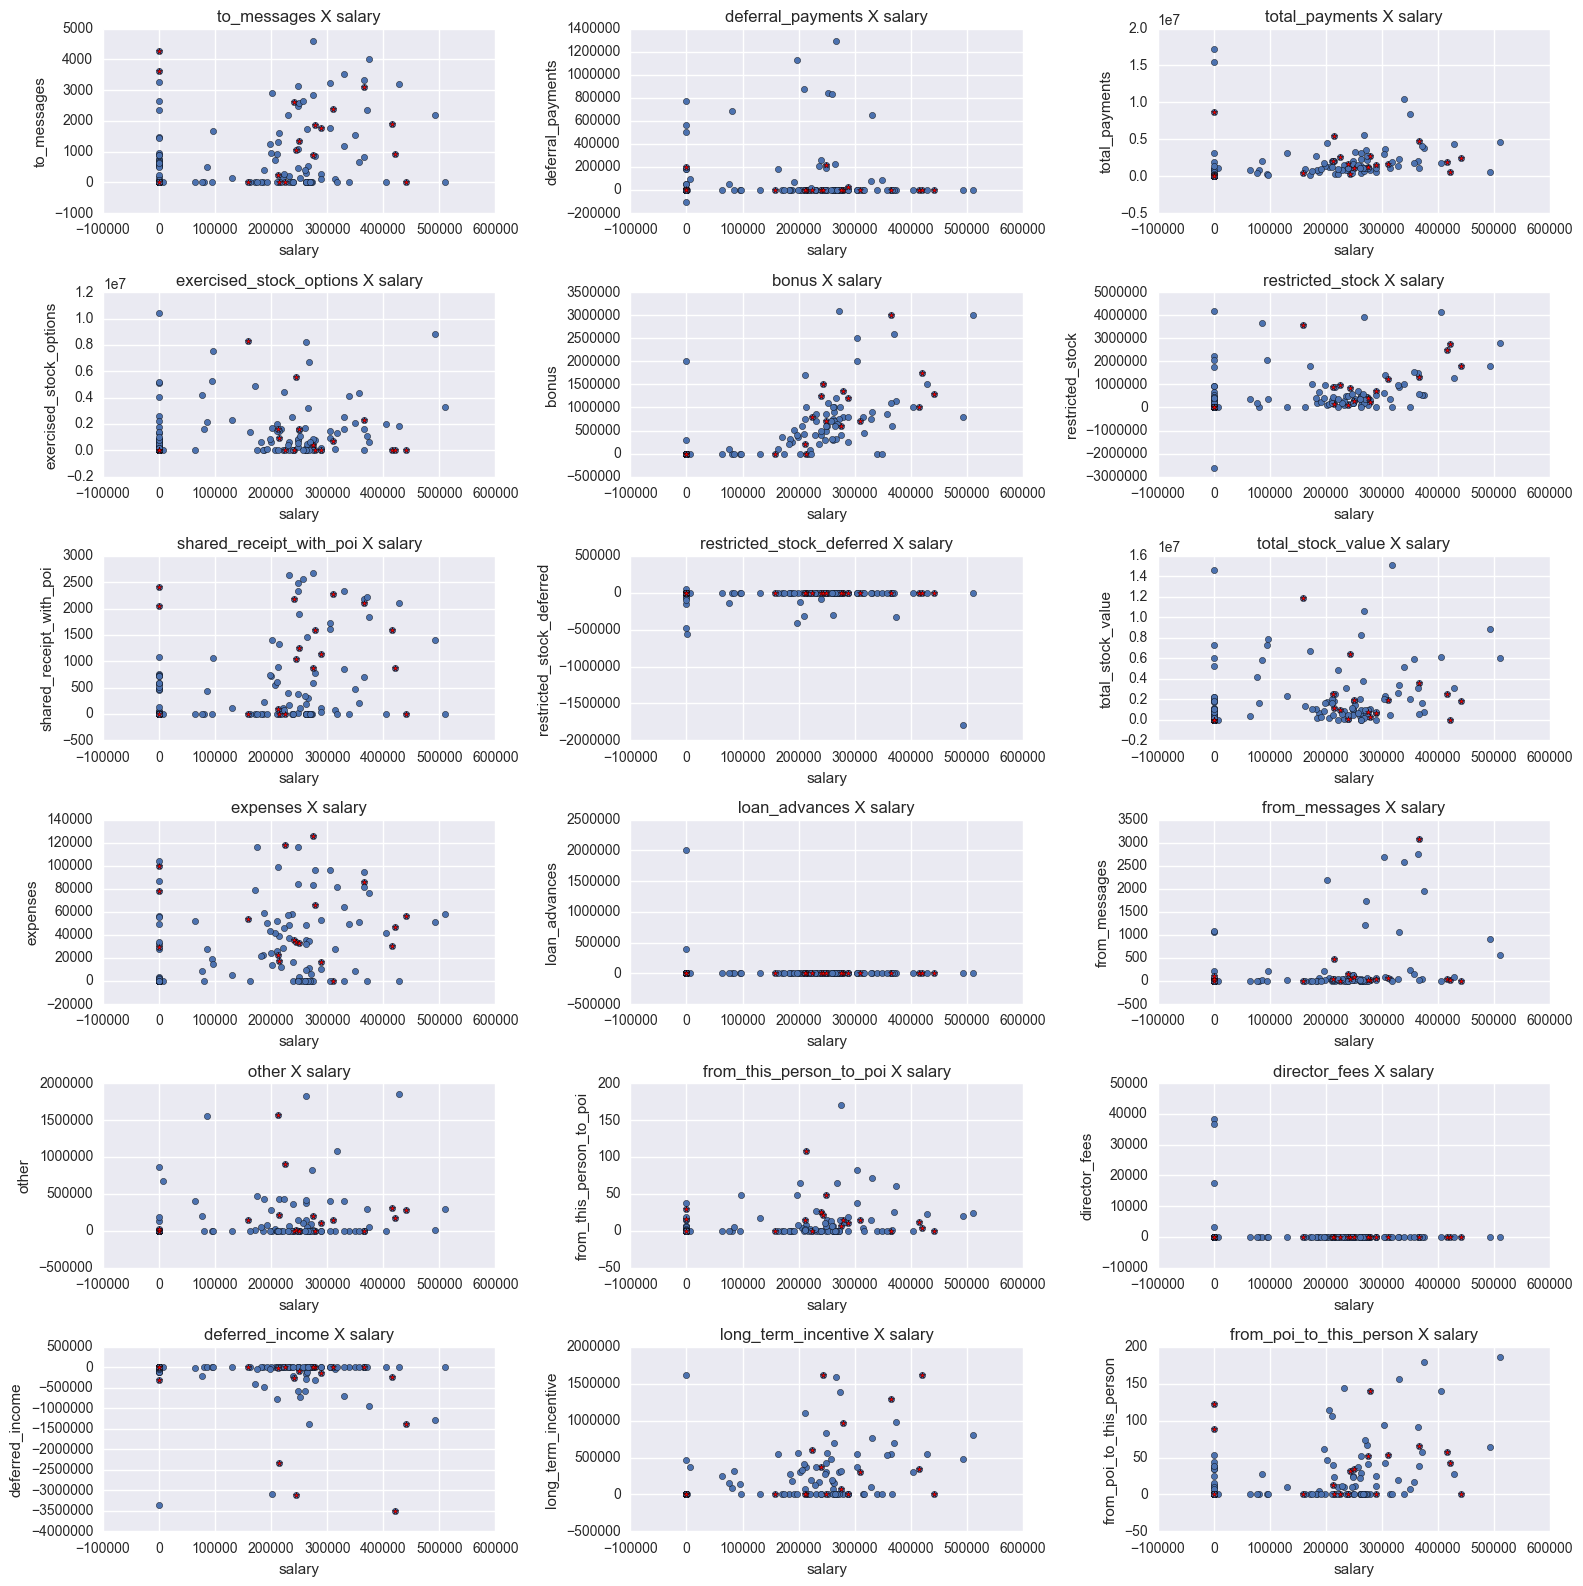

In [13]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16,16))

for i, tp in enumerate(comb_list):
    if tp[0] == 'salary' and tp[1] != 'poi' and tp[1] != 'email_address':
        generate_scatter_plot(tp[0], tp[1], axes[i/3][i%3])

plt.tight_layout()

---
After dealing with the identified outliers, let's do some **Feature Engineering**.

### Feature Engineering

We can try to extract more information from the features that we already have by modifying them in a way that the *Machine Learning* models can have its performance enhanced.

---

In [14]:
display(enron_df[['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi']].head(3))

enron_df['from_poi_percent'] = enron_df['from_poi_to_this_person'] / enron_df['to_messages']
enron_df['to_poi_percent'] = enron_df['from_this_person_to_poi'] / enron_df['from_messages']
enron_df['more_to_than_from'] = np.where(enron_df['to_messages'] / enron_df['from_messages'] > 1, 1, 0)

### Replacing NaN's
for col in ['from_poi_percent','to_poi_percent','more_to_than_from']:
    enron_df.loc[pd.isnull(enron_df[col]), col] = 0
    enron_df.loc[~np.isfinite(enron_df[col]), col] = 0


enron_df[['to_messages', 'from_poi_to_this_person', 'from_poi_percent',\
          'from_messages', 'from_this_person_to_poi', 'to_poi_percent', 'more_to_than_from']].head(3)

,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi
ALLEN PHILLIP K,2902,47,2195,65
BADUM JAMES P,0,0,0,0
BANNANTINE JAMES M,566,39,29,0


,to_messages,from_poi_to_this_person,from_poi_percent,from_messages,from_this_person_to_poi,to_poi_percent,more_to_than_from
ALLEN PHILLIP K,2902,47,0.016196,2195,65,0.029613,1
BADUM JAMES P,0,0,0.000000,0,0,0.000000,0
BANNANTINE JAMES M,566,39,0.068905,29,0,0.000000,1


---
Three variables were created: ***from_poi_percent***, ***to_poi_percent*** and ***more_to_than_from***.

Two of them present a more precise measure over how each person used to exchange messages with ***POIs***.
And the other one, shows if a person tended to receive more emails than send.

### Splitting the data set
To use the _classifiers_ we need to split our data into two parts: **Train & Test**.

---

In [15]:
### Splitting data into Train x Test
from sklearn import model_selection

enron_df.drop(['email_address'], axis=1, inplace=True)

features = enron_df.drop(['poi'], axis=1)
labels = enron_df['poi']

features_train, features_test, labels_train, labels_test = model_selection.train_test_split(
    features.values, labels, test_size=0.3, random_state=42)

In [16]:
### Columns with negative values
(enron_df.T < 0).any(1)

salary                       False
to_messages                  False
deferral_payments             True
total_payments               False
exercised_stock_options      False
bonus                        False
restricted_stock              True
shared_receipt_with_poi      False
restricted_stock_deferred     True
total_stock_value             True
expenses                     False
loan_advances                False
from_messages                False
other                        False
from_this_person_to_poi      False
poi                          False
director_fees                False
deferred_income               True
long_term_incentive          False
from_poi_to_this_person      False
from_poi_percent             False
to_poi_percent               False
more_to_than_from            False
dtype: bool

---
### Rescaling
---

In [17]:
### Dealing with negative values for further use
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

---
### Selecting & Analyzing
Once we made some data engineering, it is time to select which features has better chances to provide interesting results.

To select these variables, I am going to use the ***SelectKBest*** function that is going to extract the best features based on the ***Chi-square*** test.

---

In [18]:
### Task 1: Select what features you'll use.
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Number of features to be selected
k = 6

### Creates and fits selector
selector = SelectKBest(chi2, k=k)
selector.fit(features_train, labels_train)

### Get idxs of columns to keep
selected_idx = selector.get_support(indices=True)

### Applies selection over features
features_train_selected = selector.transform(features_train)
features_test_selected = selector.transform(features_test)

columns_list = enron_df[selected_idx].columns.tolist()
columns_list

['to_messages',
 'shared_receipt_with_poi',
 'expenses',
 'from_this_person_to_poi',
 'long_term_incentive',
 'from_poi_percent']

---
The number of features to be selected was defined by experimenting a range of values, from *2* to *8*.

Using the *AdaBoost* classifier as base, I've found that ***k=6*** presented the best results.

<table style="border: none; width: 350px; margin-left: 30px; font-size: 10px">
     <tr style="border: none;">
         <th style="border: none; border-right: 1px solid #42a5f5";>K</th>
         <th style="border: none; border-right: 1px solid #42a5f5; text-align: center">Accuracy</th>
         <th style="border: none; border-right: 1px solid #42a5f5; text-align: center">Precision</th>
         <th style="border: none; text-align: center">Recall</th>
     </tr>
     <tr style="border-right: none; border-left: none;">
         <td style="border-color: #42a5f5; border-left: none;">= 2</td>
         <td style="border-color: #42a5f5; color: green; text-align: center">84.2%</td>
         <td style="border-color: #42a5f5; color: red; text-align: center">26.0%</td>
         <td style="border-color: #42a5f5; color: red; text-align: center;border-right: none">14.1%</td>
     </tr>
     <tr style="border-right: none; border-left: none;">
         <td style="border-left: none; border-color: #42a5f5;">= 3</td>
         <td style="border-color: #42a5f5; color: red; text-align: center;">79.9%</td>
         <td style="border-color: #42a5f5; color: green; text-align: center;">34.5%</td>
         <td style="border-color: #42a5f5; color: red; text-align: center; border-right: none">22.6%</td>
     </tr>
     <tr style="border-right: none; border-left: none;">
         <td style="border-left: none; border-color: #42a5f5;">= 4</td>
         <td style="border-color: #42a5f5; color: red; text-align: center;">79.6%</td>
         <td style="border-color: #42a5f5; color: red; text-align: center;">33.5%</td>
         <td style="border-color: #42a5f5; color: red; text-align: center; border-right: none">22.4%</td>
     </tr>
     <tr style="border-right: none; border-left: none;">
         <td style="border-left: none; border-color: #42a5f5;">= 5</td>
         <td style="border-color: #42a5f5; color: red; text-align: center;">80.5%</td>
         <td style="border-color: #42a5f5; color: red; text-align: center;">28.1%</td>
         <td style="border-color: #42a5f5; color: red; text-align: center; border-right: none">17.2%</td>
     </tr>
     <tr style="border-right: none; border-left: none; background: #eaf5fe; font-size: 12px">
         <td style="border-left: none; border-color: #42a5f5; font-weight: bold">= 6</td>
         <td style="border-color: #42a5f5; text-align: center; font-weight: bold">80.8%</td>
         <td style="border-color: #42a5f5; text-align: center; font-weight: bold">33.9%</td>
         <td style="border-color: #42a5f5; text-align: center; font-weight: bold; border-right: none">25.6%</td>
     </tr>
     <tr style="border-right: none; border-left: none;">
         <td style="border-left: none; border-color: #42a5f5;">= 7</td>
         <td style="border-color: #42a5f5; color: green; text-align: center;">82.4%</td>
         <td style="border-color: #42a5f5; color: red; text-align: center;">33.4%</td>
         <td style="border-color: #42a5f5; color: red; text-align: center; border-right: none">22.8%</td>
     </tr>
     <tr style="border-right: none; border-left: none; border-bottom: none;">
         <td style="border-bottom: none; border-left: none; border-color: #42a5f5;">= 8</td>
         <td style="border-bottom: none; color: green; border-color: #42a5f5; text-align: center;">82.4%</td>
         <td style="border-bottom: none; color: red; border-color: #42a5f5; text-align: center;">33.3%</td>
         <td style="border-bottom: none; color: red; border-color: #42a5f5; text-align: center; border-right: none">22.5%</td>
     </tr>
 </table>

### Analyzing selected features
---

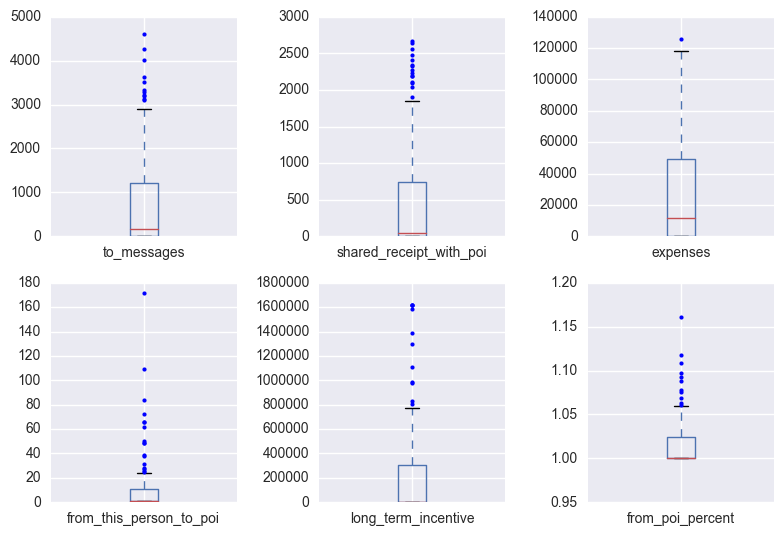

In [19]:
fig, axes = plt.subplots(2, 3)

if 'poi' in columns_list:
    columns_list.remove('poi')
    
for i, x in enumerate(columns_list):
    ax=(enron_df[x]+1).plot(kind='box', ax=axes[i/3][i%3], sym='k.')

plt.tight_layout()

In [20]:
def feature_details(df, feature, top_n=5, quantile=.95):
    col_idx = enron_df.columns.get_loc(feature)
    
    print '-------------------------\n{} score: '.format(feature), selector.scores_[col_idx]
    display(df[[feature, 'poi']].sort_values(by=feature, ascending=False)[:top_n])
    print '{}% of the data are less than or equal to the following value: '.format(quantile*100)\
        ,df[feature].quantile(quantile)

In [21]:
for c in columns_list:
    feature_details(enron_df, c)

-------------------------
to_messages score:  2.47531548337


,to_messages,poi
KAMINSKI WINCENTY J,4607,False
LAY KENNETH L,4273,True
HAEDICKE MARK E,4009,False
SKILLING JEFFREY K,3627,True
BUY RICHARD B,3523,False


95.0% of the data are less than or equal to the following value:  3217.6
-------------------------
shared_receipt_with_poi score:  5.35237589812


,shared_receipt_with_poi,poi
LEFF DANIEL P,2672,False
BECK SALLY W,2639,False
SUNDE MARTIN,2565,False
SHARP VICTORIA T,2477,False
LAY KENNETH L,2411,True


95.0% of the data are less than or equal to the following value:  2266.7
-------------------------
expenses score:  2.88857974925


,expenses,poi
GLISAN JR BEN F,125978,True
KOPPER MICHAEL J,118134,True
SHARP VICTORIA T,116337,False
KISHKILL JOSEPH G,116335,False
WAKEHAM JOHN,103773,False


95.0% of the data are less than or equal to the following value:  96233.6
-------------------------
from_this_person_to_poi score:  1.23031946648


,from_this_person_to_poi,poi
KAMINSKI WINCENTY J,171,False
BELDEN TIMOTHY N,108,True
SHANKMAN JEFFREY A,83,False
BUY RICHARD B,71,False
ALLEN PHILLIP K,65,False


95.0% of the data are less than or equal to the following value:  48.9
-------------------------
long_term_incentive score:  1.56927820115


,long_term_incentive,poi
RICE KENNETH D,1617011,True
FREVERT MARK A,1617011,False
HANNON KEVIN P,1617011,True
BAXTER JOHN C,1586055,False
LEFF DANIEL P,1387399,False


95.0% of the data are less than or equal to the following value:  982440.7
-------------------------
from_poi_percent score:  4.90920290583


,from_poi_percent,poi
DEFFNER JOSEPH M,0.161064,False
DURAN WILLIAM D,0.117257,False
UMANOFF ADAM S,0.108108,False
JACKSON CHARLENE R,0.096899,False
CARTER REBECCA C,0.092949,False


95.0% of the data are less than or equal to the following value:  0.0747053140464


---
With the _box plots_ and _tables_ above we can have an idea over how the data from each feature is spread.

Besides that we can see the score that was assigned to each feature selected by the *SelectKBest* (the higher, the best)

### Machine Learning Models

---

In [22]:
### Testing different Machine Learning approaches
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score

classifiers_params = {
    'AdaBoost': {
        'clf': AdaBoostClassifier(),
        'parameters': {
            'learning_rate': [1, 1.2, 1.25, 1.3, 1.35, 1.4],
            'n_estimators': [5],
            'random_state': [511]    
        }
    },
    'Decision Tree': {
        'clf': DecisionTreeClassifier(),
        'parameters': {
            'min_samples_split': [2,4,8,10,15,20,30,50],
            'max_depth': [1,3,7,9,14,19,29,49],
            'max_features': [1,3,5,'auto','sqrt','log2'],
            'random_state': [511]
        }        
    },
    'KNN': {
        'clf': KNeighborsClassifier(),
        'parameters': {
            'n_neighbors': [1, 3, 5, 7, 9, 15, 25, 30, 50]
        }
    },
    'Naive Bayes': {
        'clf': GaussianNB(),
        'parameters': {}
    },
    'Random Forest': {
        'clf': RandomForestClassifier(),
        'parameters': {
            'n_estimators': [1, 5, 10],
            'min_samples_split': [2,4,8,10,15],
            'max_depth': [1,3,7,9,14],
            'max_features': [1,3,5],
            'random_state': [511]
        }
    },
    'SVM': {
        'clf': SVC(),
        'parameters': {
            'C': [.1, .3, .5, .7] + range(1,10),
            'gamma': [1. / 800,  1. / 400, 1. / 200, 'auto'],
            'random_state': [511]
        }
    }
}

In [196]:
from sklearn.model_selection import GridSearchCV

result = {}

my_dataset = enron_df.to_dict(orient='index')
features_list = ['poi'] + columns_list

for clf_param in sorted(classifiers_params.keys()):
    ### Using GridSearchVC to validate the classifier
    clf_obj = classifiers_params[clf_param]['clf']
    parameters = classifiers_params[clf_param]['parameters']
    clf = GridSearchCV(clf_obj, parameters, scoring=['precision', 'recall'], refit='precision')

    clf.fit(features_train_selected, labels_train)

    result[clf_param] = {
            'classifier': clf.best_estimator_,
            'accuracy_score': accuracy_score(labels_test, pred),
            'precision_score': precision_score(labels_test, pred),
            'recall_score': recall_score(labels_test, pred)
        } 
    
    test_classifier(clf.best_estimator_, my_dataset, features_list)
    print

clf = result['AdaBoost']['classifier']

dump_classifier_and_data(clf, my_dataset, features_list)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.2, n_estimators=5, random_state=511)
	Accuracy: 0.83769	Precision: 0.46309	Recall: 0.34500	F1: 0.39542	F2: 0.36354
	Total predictions: 13000	True positives:  690	False positives:  800	False negatives: 1310	True negatives: 10200


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            presort=False, random_state=511, splitter='best')
	Accuracy: 0.81069	Precision: 0.20562	Recall: 0.08050	F1: 0.11570	F2: 0.09165
	Total predictions: 13000	True positives:  161	False positives:  622	False negatives: 1839	True negatives: 10378


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='unifo

---
From the classifiers used above, the best scores were achieved by **AdaBoost**\*.
<p style="font-size: 9px">* Check the table in the <b>last section</b> below to have a better picture over the achieved scores</p>

### Testing Classifier w/ new features
Since I used **SelectKBest**, the featuares that I created were not used.

With the same classifier that we found in the last section, let's train and test it using those new features to see what happens with the scores.

---

In [31]:
### Defining a list of features that contains the new variables
### This new list has the same length used by the SelectKBest
features = enron_df[['from_poi_percent', 'to_poi_percent', 'more_to_than_from',\
                     'long_term_incentive', 'expenses', 'shared_receipt_with_poi']]
labels = enron_df['poi']

### Splitting and Scaling the data in the same way as before
features_train, features_test, labels_train, labels_test = model_selection.train_test_split(
    features.values, labels, test_size=0.3, random_state=42)

scaler = MinMaxScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

### Testing classifier
clf = AdaBoostClassifier(learning_rate=1.2, n_estimators=5, random_state=511)
clf.fit(features_train, labels_train)

features_list = ['poi'] + features.columns.tolist()

test_classifier(clf, my_dataset, features_list)

dump_classifier_and_data(clf, my_dataset, features_list)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.2, n_estimators=5, random_state=511)
	Accuracy: 0.84262	Precision: 0.48663	Recall: 0.41850	F1: 0.45000	F2: 0.43056
	Total predictions: 13000	True positives:  837	False positives:  883	False negatives: 1163	True negatives: 10117



---
For the first attempt, using _SelectKBest_, the scores were:
 * Accuracy: **83.8%**
 * Precision: **46.3%**
 * Recall: **34.5%**
 
And now, using the _new features_ we had an improvement:
 * Accuracy: **84.3%**
 * Precision: **48.7%**
 * Recall: **41.8%**

These new scores have defined the final classifier.

---

---
### Enron Submission Free-Response Questions

1\. **Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]**

 > By using _Machine Learning_ models, it would be possible to identify people who could be involved in frauds. This dataset presents lots of informations related to ***POIs*** and by learning about their behaviour maybe we could identify a pattern and use it classify new data.
 
 > The dataset presented outliers, to identify them, statistical metrics such as mean and standard deviation were used. Besides that, the values within the dataset were independently analyzed with the intent of finding anomalies or data that was not going to be relevant. 
 
 > Three anomalies were removed: the **TOTAL** row; the **LOCKHART EUGENE E**; and the **THE TRAVEL AGENCY IN THE PARK**. The other outliers had its values altered.


2\. **What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]**

 > The features used were the following:
 - ['to_messages', 'shared_receipt_with_poi', 'expenses', 'other', 'from_this_person_to_poi', 'long_term_incentive', 'from_poi_percent']
 
 > They were selected using *SelectKBest*.
 
 > Since the dataset presented some features with negative values, I used *MinMaxScaler* so the features could be properly used in the methods.
 
 > Three features were created: *from_poi_percent*, *to_poi_percent* and *more_to_than_from*. As mentioned before, the first two features would describe how a person and a POI shared information in a more precise way by looking to the proportion of sent and received emails to/from POI; the later would show if a person tended to receive more emails than send.

3\. **What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]**
 
 > The selected algorithm was **AdaBoost**. I've tried _SVM_, _Naive Bayes_, _Random Forest_, _Decision Tree_ and _Nearest Neighbors_. For the other algorithms I've found accuracy scores that were close to AdaBoost's, but recall and precision were very low. 
 
 > In the table below we can check the scores for each:
 
 > <table style="border: none; width: 350px; margin-left: 30px; font-size: 10px">
     <tr style="border: none;">
         <th style="border: none; border-right: 1px solid #42a5f5";>Classifier</th>
         <th style="border: none; border-right: 1px solid #42a5f5; text-align: center">Accuracy</th>
         <th style="border: none; border-right: 1px solid #42a5f5; text-align: center">Precision</th>
         <th style="border: none; text-align: center">Recall</th>
     </tr>
     <tr style="border-right: none; border-left: none; font-weight: bold">
         <td style="border-color: #42a5f5; border-left: none;">AdaBoost</td>
         <td style="color: red; border-color: #42a5f5; text-align: center">83.8%</td>
         <td style="color: red; border-color: #42a5f5; text-align: center">46.3%</td>
         <td style="color: red; border-color: #42a5f5; text-align: center; border-right: none">34.5%</td>
     </tr>
     <tr style="border-right: none; border-left: none; background: #eaf5fe; font-size: 12px; font-weight: bold">
         <td style="border-color: #42a5f5; border-left: none;">AdaBoost (new features)</td>
         <td style="border-color: #42a5f5; text-align: center">84.3%</td>
         <td style="border-color: #42a5f5; text-align: center">48.7%</td>
         <td style="border-color: #42a5f5; text-align: center; border-right: none">41.8%</td>
     </tr>
     <tr style="border-right: none; border-left: none;">
         <td style="border-left: none; border-color: #42a5f5; font-weight: bold">Decision Tree</td>
         <td style="color: red; border-color: #42a5f5; text-align: center;">81.0%</td>
         <td style="color: red; border-color: #42a5f5; text-align: center;">20.6%</td>
         <td style="color: red; border-color: #42a5f5; text-align: center; border-right: none">8.0%</td>
     </tr>
     <tr style="border-right: none; border-left: none;">
         <td style="border-left: none; border-color: #42a5f5; font-weight: bold">KNN</td>
         <td style="color: red; border-color: #42a5f5; text-align: center;">82.5%</td>
         <td style="color: red; border-color: #42a5f5; text-align: center;">0.7%</td>
         <td style="color: red; border-color: #42a5f5; text-align: center; border-right: none">0.1%</td>
     </tr>
     <tr style="border-right: none; border-left: none;">
         <td style="border-left: none; border-color: #42a5f5; font-weight: bold">Naive Bayes</td>
         <td style="color: red; border-color: #42a5f5; text-align: center;">78.6%</td>
         <td style="color: red; border-color: #42a5f5; text-align: center;">30.6%</td>
         <td style="color: red; border-color: #42a5f5; text-align: center; border-right: none">30.7%</td>
     </tr>
     <tr style="border-right: none; border-left: none;">
         <td style="border-left: none; border-color: #42a5f5; font-weight: bold">Random Forest</td>
         <td style="color: red; border-color: #42a5f5; text-align: center;">82.8%</td>
         <td style="color: red; border-color: #42a5f5; text-align: center;">25.2%</td>
         <td style="color: red; border-color: #42a5f5; text-align: center; border-right: none">5.8%</td>
     </tr>
     <tr style="border-right: none; border-left: none; border-bottom: none;">
         <td style="border-bottom: none; border-left: none; border-color: #42a5f5; font-weight: bold">SVM RBF</td>
         <td style="border-bottom: none; border-color: #42a5f5; text-align: center;">-</td>
         <td style="border-bottom: none; border-color: #42a5f5; text-align: center;">-</td>
         <td style="border-bottom: none; border-color: #42a5f5; text-align: center; border-right: none">-</td>
     </tr>
 </table>
 
 > Besides **AdaBoost**, **Naive Bayes** also presented scores above the defined threshold (30%) for recall and precision.

4\. **What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]**

 > Tuning the parameters of an algorithm means to change the values of the parameters, experimenting which combinations can provide better results.
 
 > A bad tuning can provide you bad results. And what do I mean by '_bad tuning_'? Applying too much tuning over the algorithm's parameters can make the whole process slow, whilst little tuning maybe won't provide the best possible results.
 
 > By using **GridSearchCV** I was able to tune the **AdaBoost** and select values for the parameters in a way that the algorithm could reach the required scores.

5\. **What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]**

 > To Validate is to test the classifier performance by providing different scenarios. 
 
 > By splitting the data into two parts, Train and Test, and by making use of the **GridSearchVC**, I was able to validate my classifier. Without splitting the data, the classifier may **overfit** and, for this reason, it will not be able to generalize.

6\. **Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]**

 > For the analysed scenario, the **AdaBoost** classifier presented the following scores:
 > - **Accuracy**: 84.3% | Probability of correctly identifying POIs and non-POIs.
 > - **Precision**: 48.7% | Probability of the predicted POIs actually being a POI. For 57% of the cases, the algorithm will say that someone is a POI, but in fact this person is not.
 > - **Recall**: 41.8% | Probability of identifying a POI provided that the person actually is a POI. For 25% of the cases, the person really is a POI, but the classifier won't consider it.

---
### Conclusion
In this project I was able to comprehend how a Machine Learning project can be developed by using different kinds of algorithms.

- First we need to understand the data in a way that later on we will be capable of applying some transformations over the dataset so it becomes possible to build more reliable models;
- After that, we will dedicate some time to experiment different classifiers and to tune their parameters;
- We will also need to be able to validade our ML model; and
- By analyzing its scores we will be able to evaluate the developed model.

For future work, we could try making use of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for _Feature Engineering_.

---
### References
---

- **Udacity** - https://classroom.udacity.com
- **Scikit-Learn** - http://scikit-learn.org
- **Matplotlib** - https://matplotlib.org/api
- **Pandas** - https://pandas.pydata.org/pandas-docs/stable/index.html
- **Stackoverflow** - https://stackoverflow.com